## Part 1: Data Exploration and Evaluation

### Summary

I am looking to become familiarized with the Lending Club loan data set

In [1]:
cd ../

/Users/fbales138/Git/loan_analysis


In [52]:
import pandas as pd
pd.set_option('display.max_colwidth',1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#### Lending Club Loan Data from Kaggle @(https://www.kaggle.com/wendykan/lending-club-loan-data)

In [3]:
loan_data = pd.read_csv('data/loan.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
lc_data_dict = pd.read_excel('data/LCDataDictionary.xlsx')

#### Checking for missing values in the column dictionary and loan data

In [5]:
lc_data_dict[pd.isnull(lc_data_dict).any(axis=1)]

,LoanStatNew,Description
151,NaN,NaN
152,NaN,* Employer Title replaces Employer Name for all loans listed after 9/23/2013


In [6]:
loan_data.columns[loan_data.isnull().all()]

Index(['id', 'member_id', 'url'], dtype='object')

The loan data and data dictionary do not have perfect overlap (See the differing key count and column count below)
I am going to see if  the differences are reconcilable so that every data column has a description

In [7]:
print('data dictionary count: {key_count} , loan data column count {col_count}'.format(key_count=lc_data_dict.dropna(axis=1).shape[0],col_count=loan_data.dropna(how='all',axis=1).shape[1]))

data dictionary count: 153 , loan data column count 142


In [8]:
# Since I will be conducting this overlap test multiple times, I creare a small function that returns the number of columns without a description
def reconcile_data_keys(loan_data:'dataframe',data_dictionary_keys:'list'):
    columns_wo_desc = [col for col in loan_data if col not in data_dictionary_keys]
    missing_col_count=len(columns_wo_desc)
    desc_wo_col = [key for key in data_dictionary_keys if key not in loan_data.columns]
    missing_key_count=len(desc_wo_col)
    print('Keys without matching column {missing_cols}. Columns without Matching Key {missing_keys}'.format(missing_cols=missing_col_count,missing_keys=missing_key_count))
    return {'missing_keys':columns_wo_desc,'missing_cols':desc_wo_col}

- Looking over the missing columns/keys, it is clear that there is overlap but I need to do some basic string formatting
- There is one column: 'verification_status_joint', that is similar to 'verification_status_joint' and my assumption is they are the same so I will modify the dictionary key
- Note that if I had more columns/keys with this issue I would employ fuzzy string matching to help me more scalably reconcile them

In [9]:
loan_data.columns = [col.strip() for col in loan_data.columns]
filtered_lc_data_dict = lc_data_dict.copy()
filtered_lc_data_dict.LoanStatNew = filtered_lc_data_dict.LoanStatNew.str.strip()

In [10]:
reconcile_data_keys(loan_data,filtered_lc_data_dict.LoanStatNew.dropna().tolist())

Keys without matching column 1. Columns without Matching Key 7


{'missing_keys': ['verification_status_joint'],
 'missing_cols': ['fico_range_high',
  'fico_range_low',
  'last_fico_range_high',
  'last_fico_range_low',
  'verified_status_joint',
  'sec_app_fico_range_low',
  'sec_app_fico_range_high']}

In [11]:
key_index=filtered_lc_data_dict.index[filtered_lc_data_dict.LoanStatNew=='verified_status_joint']
filtered_lc_data_dict.at[key_index,'LoanStatNew']='verification_status_joint'

In [12]:
reconcile_data_keys(loan_data,filtered_lc_data_dict.LoanStatNew.dropna().tolist())

Keys without matching column 0. Columns without Matching Key 6


{'missing_keys': [],
 'missing_cols': ['fico_range_high',
  'fico_range_low',
  'last_fico_range_high',
  'last_fico_range_low',
  'sec_app_fico_range_low',
  'sec_app_fico_range_high']}

#### I created a  data dictionary with the altered inputs and just the data columnsm

In [13]:
filtered_lc_data_dict = filtered_lc_data_dict[filtered_lc_data_dict.LoanStatNew.isin(loan_data.columns)]
filtered_lc_data_dict.to_excel('data/filtered_lc_data_dict.xlsx',index=False)

In [14]:
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'],format='%b-%Y')

#### If we are interested in just looking at the loan origination data frin 2007 to 2015, run the following cell

In [15]:
start_date = '2007-01-01'
end_date = '2016-01-01'
loan_data = loan_data.loc[(loan_data['issue_d'] > start_date)&(loan_data['issue_d']<end_date)]

In [16]:
agg_dict = {
            'int_rate':['mean','median']
            ,'loan_amnt':['sum']
            
}

In [18]:
loan_data.groupby([loan_data.issue_d.dt.year,'grade']).agg(agg_dict).sort_index()

int_rate          loan_amnt
                    mean median         sum
issue_d grade                              
2007    A      7.757564   7.75   391200    
        B      9.418163   9.33   817100    
        C      10.847589  10.91  1166875   
        D      12.551616  12.49  792550    
        E      14.125000  14.07  813825    
        F      15.578462  15.49  616250    
        G      17.364857  17.54  379675    
2008    A      8.357044   8.32   1982575   
        B      10.366077  10.39  5449775   
        C      11.834621  11.78  5127250   
        D      13.363819  13.30  3759325   
        E      14.808772  14.82  2561825   
        F      16.290270  16.15  1236275   
        G      18.105233  18.29  1002225   
2009    A      8.637664   8.94   8700675   
        B      11.791204  11.83  15695475  
        C      13.320950  13.22  13182425  
        D      14.930979  14.96  8700125   
        E      16.494935  16.35  3665175   
        F      18.243810  18.21  1328225   
        G      20.007455  20.11  656150    
2010    A      7.145756   7.14   24824350  
        B      10.737998  10.75  40253325  
        C      13.485115  13.48  27447875  
        D      15.286355  15.21  20708000  
        E      16.910873  16.82  11791925  
        F      18.694855  18.67  4570050   
        G      20.660075  20.53  2397025   
2011    A      7.107155   7.29   51657300  
        B      11.080778  10.99  74656100  
...                  ...    ...      ...   
        F      20.382493  20.62  14562175  
        G      21.960690  22.11  4315950   
2012    A      7.611371   7.90   121476925 
        B      12.149683  12.12  219668150 
        C      15.265656  15.31  153419000 
        D      18.417302  18.49  113862325 
        E      21.059149  21.00  70276075  
        F      23.091916  23.26  32853525  
        G      24.495096  24.70  6855025   
2013    A      7.744015   7.90   270784350 
        B      11.811538  11.99  595898525 
        C      15.540343  15.61  567091400 
        D      18.685183  18.55  283641225 
        E      21.724041  21.60  161329875 
        F      23.976638  23.76  84437275  
        G      25.509074  25.80  19582625  
2014    A      7.471188   7.69   523412775 
        B      11.187983  11.44  844292375 
        C      14.149896  14.16  963542750 
        D      17.116043  16.99  689507475 
        E      20.358002  20.20  345506050 
        F      24.241438  24.08  104298375 
        G      25.857217  25.83  33280375  
2015    A      6.941603   6.92   1077445350
        B      10.044267  9.99   1676097950
        C      13.297921  13.33  1777831825
        D      16.723292  16.99  999154850 
        E      19.290046  18.99  645584850 
        F      23.612884  23.99  197226225 
        G      26.835187  26.77  44267125  

[63 rows x 3 columns]

In [19]:
loan_data.purpose.value_counts()

debt_consolidation    524253
credit_card           206194
home_improvement      51834 
other                 42896 
major_purchase        17277 
small_business        10378 
car                   8864  
medical               8541  
moving                5415  
vacation              4736  
house                 3707  
wedding               2347  
renewable_energy      575   
educational           423   
Name: purpose, dtype: int64

In [72]:
completed_loans = ['Fully Paid','Charged Off','Default','Does not meet the credit policy. Status:Fully Paid'
                   ,'Does not meet the credit policy. Status:Charged Off']
fully_paid_list = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']
loan_status_dict={
                    'Does not meet the credit policy. Status:Fully Paid':'Fully Paid'
                    ,'Does not meet the credit policy. Status:Charged Off':'Charged Off'
                }

In [138]:
int_data = loan_data.copy()
int_data = int_data.loc[int_data['loan_status'].isin(completed_loans)]
int_data['loan_status'] = int_data['loan_status'].apply(lambda x: loan_status_dict[x] if x in loan_status_dict else x)

In [187]:
int_data['issue_d'] = pd.to_datetime(int_data['issue_d'],format='%b-%Y')

In [188]:
int_data['issue_d_year'] = int_data['issue_d'].dt.year

In [210]:
int_data.columns = [col.strip() for col in int_data.columns]
loan_trends=pd.pivot_table(columns='loan_status',index='issue_d_year',values='funded_amnt_inv',aggfunc=['count','sum'],data=int_data)
loan_trends['Percent Defaulted'] = loan_trends[('count','Charged Off')]/(loan_trends[('count','Charged Off')]+loan_trends[('count','Fully Paid')])*100
loan_trends['Total Invested $M'] = (loan_trends[('sum','Charged Off')]+loan_trends[('sum','Fully Paid')])/1000000


In [211]:
loan_trends

count                      sum                \
loan_status  Charged Off Fully Paid   Charged Off    Fully Paid   
issue_d_year                                                      
2007          158         445        2.057269e+05  5.936579e+05   
2008          496         1897       1.382052e+06  6.232331e+06   
2009          723         4558       6.255579e+06  3.952230e+07   
2010          1757        10780      1.700468e+07  1.060799e+08   
2011          3297        18424      4.143726e+07  2.125888e+08   
2012          8644        44723      1.268224e+08  5.898837e+08   
2013          21022       113771     3.296862e+08  1.651673e+09   
2014          41056       180412     6.388046e+08  2.581782e+09   
2015          75275       298137     1.181792e+09  4.272593e+09   

             Percent Defaulted Total Invested $M  
loan_status                                       
issue_d_year                                      
2007          26.202322         0.799385          
2008          20.727121         7.614383          
2009          13.690589         45.777878         
2010          14.014517         123.084628        
2011          15.178859         254.026023        
2012          16.197275         716.706129        
2013          15.595765         1981.359263       
2014          18.538118         3220.586850       
2015          20.158699         5454.385800

In [221]:
pd.DataFrame(loan_trends['Percent Defaulted'].describe())

,Percent Defaulted
count,9.000000
mean,17.811474
std,4.043344
min,13.690589
25%,15.178859
50%,16.197275
75%,20.158699
max,26.202322


In [208]:
loan_trends.index

Int64Index([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype='int64', name='issue_d_year')

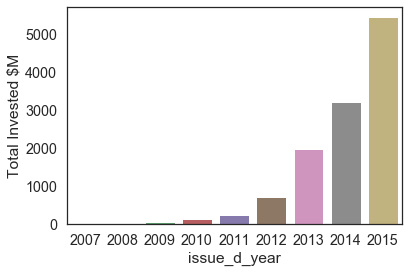

In [219]:
loan_trend_plot=sns.barplot(data=loan_trends,x=loan_trends.index,y='Total Invested $M')
interest_rate_plot.set(xlabel='Interest Percentile',ylabel='Loan Count',title='Loan Outcome by Interest Rate Percentile')
#plt.twinx()
#loan_volume = int_pivot_df.groupby('int_perc').agg({'sum':'sum'})
#loan_volume = loan_volume/1000000
#loan_volume.columns = ['Total Investor Funding ($M)']
#sns.lineplot(data=loan_trends,x=loan_trends.index,y='Percent Defaulted')# df.column2, color="b", ax=ax2)
interest_rate_plot.legend(loc=2, ncol=1)

plt.savefig('figs/loan_trends.png')

In [139]:
percentile_labels = [str(i)+'th' for i in range(10,110,10)]
int_data['int_perc'] = pd.qcut(int_data['int_rate'],10,labels=percentile_labels)

In [166]:
int_data['purpose'].value_counts()

debt_consolidation    485982
credit_card           190351
home_improvement      48287 
other                 41131 
major_purchase        16335 
small_business        9970  
car                   8520  
medical               8191  
moving                5259  
vacation              4653  
house                 3566  
wedding               2347  
renewable_energy      560   
educational           423   
Name: purpose, dtype: int64

In [183]:
top_purposes=['debt_consolidation'    
,'credit_card'           
,'home_improvement '      
,'other '                 
,'major_purchase' 
,'small_business'
   ,'car'
   ,'Medical']

In [184]:
purpose_dict={'debt_consolidation':'Debt Consolidation' 
,'credit_card' :'Credit Card'   
,'home_improvement ' :'Home Improvement'     
,'other ' :'Other'           
,'major_purchase':'Major Purchase'
,'small_business':'Small Business'
   ,'car':'Car'
   ,'Medical':'Medical'}

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


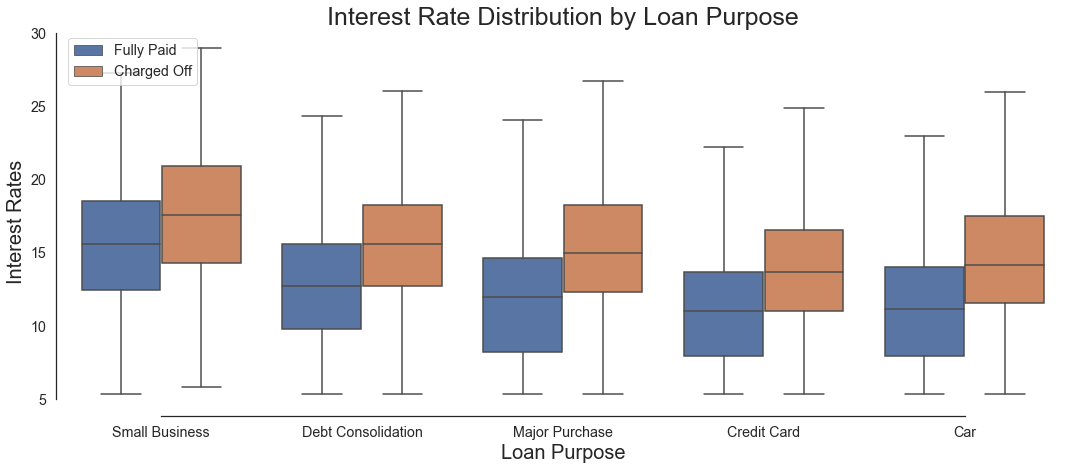

In [182]:
plot_data = int_data.loc[int_data['purpose'].isin(top_purposes)]
plot_data['purpose'] = plot_data['purpose'].apply(lambda x:dictt[x])
sns.set(style="white",font_scale = 1.3)
plt.figure(figsize=(18, 7))
ax = sns.boxplot(x='purpose', y='int_rate', data=plot_data,showfliers=False,hue='loan_status')
sns.despine(offset=5, trim=True);
ax.set_title(f'Interest Rate Distribution by Loan Purpose',size=25)
ax.set_xlabel('Loan Purpose',size=20)
ax.set_ylabel(f'Interest Rates',size=20)
ax.legend(loc=2, ncol=1)
plt.savefig('figs/loan_purpose_box_plots.png')

In [155]:
int_corr=int_data[['int_rate','funded_amnt_inv','loan_status']]
dummies = pd.get_dummies(int_corr[['loan_status']],drop_first=True)
int_corr=int_corr.drop(['loan_status'],axis=1)
int_corr = pd.concat([int_corr,dummies],axis=1)
int_corr.columns = ['Interest Rate','Investor Funding','Loan Fully Paid']
int_corr_matrix=int_corr.corr()

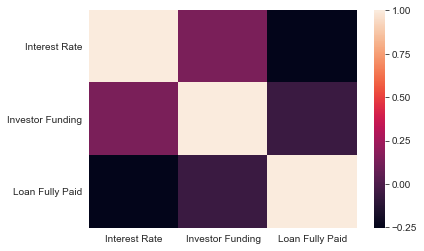

In [141]:
sns.heatmap(int_corr_matrix, 
        xticklabels=int_corr_matrix.columns,
        yticklabels=int_corr_matrix.columns)
plt.savefig('data/int_corr.png')

In [142]:
int_pivot_df=pd.pivot_table(data=int_data,index='int_perc',columns='loan_status',values='funded_amnt_inv',aggfunc=['count','sum'])
int_pivot_df=int_pivot_df.stack(level=1).reset_index(level=1)
int_pivot_df = int_pivot_df.rename(columns={'loan_status':'Loan Outcome'})
int_pivot_df

,Loan Outcome,count,sum
int_perc,,,
10th,Charged Off,3818,5.023650e+07
10th,Fully Paid,83435,1.154162e+09
20th,Charged Off,6376,8.732612e+07
20th,Fully Paid,73414,1.034251e+09
30th,Charged Off,8872,1.188081e+08
30th,Fully Paid,71762,9.547587e+08
40th,Charged Off,12318,1.645961e+08
40th,Fully Paid,80903,1.053235e+09
50th,Charged Off,14629,1.996423e+08


In [148]:
int_pivot_df['mean_inv'] = int_pivot_df['sum']/int_pivot_df['count']
int_pivot_df

,Loan Outcome,count,sum,mean_inv
int_perc,,,,
10th,Charged Off,3818,5.023650e+07,13157.805528
10th,Fully Paid,83435,1.154162e+09,13833.064295
20th,Charged Off,6376,8.732612e+07,13696.066094
20th,Fully Paid,73414,1.034251e+09,14087.931956
30th,Charged Off,8872,1.188081e+08,13391.356926
30th,Fully Paid,71762,9.547587e+08,13304.516548
40th,Charged Off,12318,1.645961e+08,13362.241001
40th,Fully Paid,80903,1.053235e+09,13018.488156
50th,Charged Off,14629,1.996423e+08,13647.020044


In [150]:
int_pivot_df.groupby('int_perc').agg({'mean_inv':'mean'}).T.round()

int_perc,10th,20th,30th,40th,50th,60th,70th,80th,90th,100th
mean_inv,13495.0,13892.0,13348.0,13190.0,13339.0,13889.0,13850.0,14912.0,15962.0,18161.0


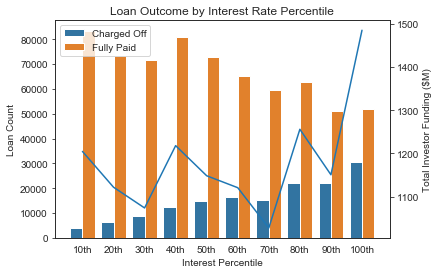

In [144]:
interest_rate_plot=sns.barplot(data=int_pivot_df,x=int_pivot_df.index,y='count',hue='Loan Outcome')
interest_rate_plot.set(xlabel='Interest Percentile',ylabel='Loan Count',title='Loan Outcome by Interest Rate Percentile')
ax2 = plt.twinx()
loan_volume = int_pivot_df.groupby('int_perc').agg({'sum':'sum'})
loan_volume = loan_volume/1000000
loan_volume.columns = ['Total Investor Funding ($M)']
sns.lineplot(data=loan_volume,x=loan_volume.index,y='Total Investor Funding ($M)')# df.column2, color="b", ax=ax2)
interest_rate_plot.legend(loc=2, ncol=1)

plt.savefig('data/int_outcome.png')

In [65]:
int_data['int_perc'].value_counts()

(10.64, 11.99]    93221
(11.99, 12.99]    87418
(5.319, 7.62]     87253
(15.31, 16.99]    85209
(18.92, 28.99]    82468
(12.99, 13.99]    81672
(8.9, 10.64]      80634
(7.62, 8.9]       79790
(13.99, 15.31]    74827
(16.99, 18.92]    73083
Name: int_perc, dtype: int64

### Given these are p2p loans, I want to understand a little bit more about who is borrowing and their loan performance characteristics

In [21]:
completed_loans = ['Fully Paid','Charged Off','Default','Does not meet the credit policy. Status:Fully Paid'
                   ,'Does not meet the credit policy. Status:Charged Off']
fully_paid_list = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']

In [22]:
borrower_data=loan_data[['annual_inc','purpose','grade','int_rate','loan_amnt','loan_status']]

In [23]:
borrower_data.head()

,annual_inc,purpose,grade,int_rate,loan_amnt,loan_status
929649,65000.0,small_business,C,11.99,24700,Fully Paid
929650,106000.0,debt_consolidation,C,12.88,35000,Charged Off
929651,70000.0,debt_consolidation,C,13.99,20000,Charged Off
929652,145000.0,debt_consolidation,C,12.88,20000,Late (31-120 days)
929653,39000.0,debt_consolidation,D,18.49,14025,Fully Paid


In [24]:
borrower_data.isnull().sum()

annual_inc     4
purpose        0
grade          0
int_rate       0
loan_amnt      0
loan_status    0
dtype: int64

In [25]:
borrower_data=borrower_data.dropna(how='any',axis=0)

In [26]:
borrower_data.annual_inc.describe()

count    8.874360e+05
mean     7.502628e+04
std      6.469670e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

In [27]:
borrower_data['income_percentiles'] = pd.qcut(borrower_data['annual_inc'],10)

In [28]:
borrower_data.head()

,annual_inc,purpose,grade,int_rate,loan_amnt,loan_status,income_percentiles
929649,65000.0,small_business,C,11.99,24700,Fully Paid,"(56000.0, 65000.0]"
929650,106000.0,debt_consolidation,C,12.88,35000,Charged Off,"(98500.0, 124800.0]"
929651,70000.0,debt_consolidation,C,13.99,20000,Charged Off,"(65000.0, 72000.0]"
929652,145000.0,debt_consolidation,C,12.88,20000,Late (31-120 days),"(124800.0, 9500000.0]"
929653,39000.0,debt_consolidation,D,18.49,14025,Fully Paid,"(34000.0, 42000.0]"


In [151]:
borrower_data.groupby('income_percentiles').agg({'int_rate':'mean','loan_amnt':'sum'})

,int_rate,loan_amnt
income_percentiles,,
"(-0.001, 34000.0]",13.977453,642728925
"(34000.0, 42000.0]",13.753182,942972125
"(42000.0, 50000.0]",13.578992,1263505225
"(50000.0, 56000.0]",13.530286,888307425
"(56000.0, 65000.0]",13.355434,1556027175
"(65000.0, 72000.0]",13.273814,985708800
"(72000.0, 83500.0]",13.100608,1484561650
"(83500.0, 98500.0]",12.861823,1609804050
"(98500.0, 124800.0]",12.616054,1740137725


#### Relatively even distribution of loan outcomes across loan purposes

In [38]:
loan_status_by_type = borrower_data.pivot_table(index='purpose',columns='loan_status',values='loan_amnt',aggfunc='count')
loan_status_by_type = loan_status_by_type.apply(lambda x: (x/x.sum()*100).round(2),axis=1)
loan_status_by_type = loan_status_by_type.drop(columns=['Does not meet the credit policy. Status:Charged Off','Does not meet the credit policy. Status:Fully Paid'])
loan_status_by_type

loan_status,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
purpose,,,,,,
car,12.78,3.68,82.62,0.03,NaN,0.17
credit_card,14.25,7.36,77.90,0.10,0.03,0.19
debt_consolidation,18.19,6.91,74.30,0.11,0.04,0.24
educational,13.24,NaN,63.83,NaN,NaN,NaN
home_improvement,15.28,6.47,77.46,0.10,0.04,0.23
house,19.77,3.56,75.24,0.03,0.05,0.16
major_purchase,15.25,5.18,78.58,0.08,0.02,0.18
medical,18.43,3.81,76.79,0.06,0.04,0.20
moving,20.37,2.71,75.90,0.04,0.02,0.11


In [39]:
borrower_data.pivot_table(index='income_percentiles',columns='purpose',values='loan_amnt',aggfunc='sum')

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
income_percentiles,,,,,,,,,,,,,,
"(-0.001, 34000.0]",8743550,157656125,382597850,716975,20795475,2852500,11675625,5693925,4325825,36327425,380225,6239900,3083025,1640500
"(34000.0, 42000.0]",8535975,229465825,585075600,367025,35563175,3385400,15183625,6959750,4418050,39625600,611575,8172125,3331150,2277250
"(42000.0, 50000.0]",9002850,308042350,790995875,235800,54428975,4662825,18528525,8454150,4523950,46537975,572375,11474700,3250175,2794700
"(50000.0, 56000.0]",5423550,210169100,570067775,147900,38765125,3354975,12703825,4778900,3033825,28067950,332575,7770250,2082650,1609025
"(56000.0, 65000.0]",9469800,367172875,992275300,234275,76001925,5916750,21871925,8624700,4315325,47154775,617475,15422250,3513275,3436525
"(65000.0, 72000.0]",5324625,232077950,629665250,187250,49261775,3416975,13539750,5691575,2373800,29770000,419425,9822000,2094950,2063475
"(72000.0, 83500.0]",7339125,354916125,939171625,156925,78799025,5791025,19971575,8402100,3793275,43320925,559425,16736300,2787925,2816275
"(83500.0, 98500.0]",7792200,380465550,1016271350,203050,95487850,6485750,22974250,8085000,4063050,43683600,551025,18551050,2758200,2432125
"(98500.0, 124800.0]",7904700,426240975,1066858325,358350,112067550,8111175,27190950,8536400,4731650,46305200,724475,24795425,3652650,2659900


In [ ]:
borrower_default_df = borrower_data.loc[borrower_data['']]

In [ ]:
what are they most likely to default on

In [ ]:
does joint filing make you statistically more likley to fully pay

In [45]:
loan_data.home_ownership.unique()

array(['MORTGAGE', 'OWN', 'RENT', 'ANY', 'NONE', 'OTHER'], dtype=object)

In [57]:
joint_app_data = loan_data[['application_type','loan_status','annual_inc','emp_length','open_acc','tot_cur_bal']]
joint_app_data=joint_app_data.loc[joint_app_data['loan_status'].isin(completed_loans)]
joint_app_data['loan_status'] = joint_app_data['loan_status'].apply(lambda x: 'defaulted' if x not in fully_paid_list else 'paid')
dummies = pd.get_dummies(joint_app_data[['application_type','loan_status']],drop_first=True)
joint_app_data=joint_app_data.drop(['application_type','loan_status'],axis=1)
joint_app_data = pd.concat([joint_app_data,dummies],axis=1)

In [58]:
corr=joint_app_data.corr()
corr

,annual_inc,open_acc,tot_cur_bal,application_type_Joint App,loan_status_paid
annual_inc,1.000000,0.138412,0.417435,-0.005808,0.042578
open_acc,0.138412,1.000000,0.243918,-0.001551,-0.034783
tot_cur_bal,0.417435,0.243918,1.000000,0.005009,0.062878
application_type_Joint App,-0.005808,-0.001551,0.005009,1.000000,-0.003344
loan_status_paid,0.042578,-0.034783,0.062878,-0.003344,1.000000


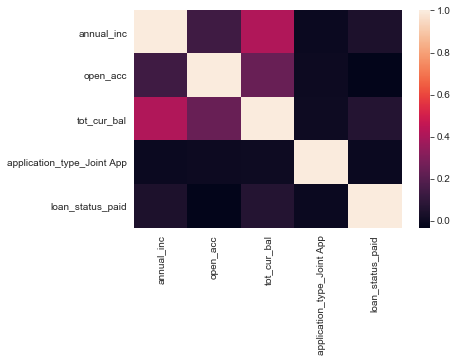

In [59]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.savefig('data')

In [ ]:
dummies = pd.get_dummies(loan_data[model_categorical_variables],drop_first=True)
model_input=loan_data.drop(model_categorical_variables,axis=1)
model_input = pd.concat([model_input,dummies],axis=1)

In [ ]:
cor

In [57]:
borrower_data.groupby('income_percentiles').agg({'int_rate':'mean','loan_amnt':'sum','purpose':'nunique'})

,purpose,int_rate,loan_amnt
income_percentiles,,,
"[0, 34000]",14,14.058562,1885990275
"(34000, 42000]",14,13.698462,2324008400
"(42000, 50000]",14,13.467843,3018358450
"(50000, 58000]",14,13.396659,2605080725
"(58000, 65000]",14,13.161835,3317287750
"(65000, 75000]",14,13.046684,3764132550
"(75000, 85000]",14,12.887793,3271644800
"(85000, 100000]",14,12.680592,4139139650
"(100000, 130000]",14,12.449931,4659040675


In [55]:
borrower_data.income_percentiles.value_counts()

(42000, 50000]         256850
(65000, 75000]         242827
(58000, 65000]         234992
(100000, 130000]       231720
[0, 34000]             229776
(34000, 42000]         228031
(85000, 100000]        226518
(130000, 110000000]    215433
(50000, 58000]         200860
(75000, 85000]         193657
dtype: int64

In [56]:
borrower_data.head()

,annual_inc,purpose,grade,int_rate,loan_amnt,loan_status,income_percentiles
0,55000,debt_consolidation,C,13.56,2500,Current,"(50000, 58000]"
1,90000,debt_consolidation,D,18.94,30000,Current,"(85000, 100000]"
2,59280,debt_consolidation,D,17.97,5000,Current,"(58000, 65000]"
3,92000,debt_consolidation,D,18.94,4000,Current,"(85000, 100000]"
4,57250,debt_consolidation,C,16.14,30000,Current,"(50000, 58000]"


In [ ]:

aborrower_data['income_bracket']

In [34]:
fully_paid_list = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']
complete_list = ['Fully Paid','Charged Off','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Default']

In [33]:
loan_data.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                919695 
Charged Off                                            261655 
Late (31-120 days)                                     21897  
In Grace Period                                        8952   
Late (16-30 days)                                      3737   
Does not meet the credit policy. Status:Fully Paid     1988   
Does not meet the credit policy. Status:Charged Off    761    
Default                                                31     
Name: loan_status, dtype: int64

In [ ]:
loan_data.loc[loan_data['loan_status'].isin(fully_paid_list)].groupby('loan_status').agg({'int_rate':'mean','total_pymnt_inv',''})

In [27]:
loan_data[['loan_status','loan_amnt','int_rate','total_pymnt_inv','out_prncp_inv',]]

,loan_status,loan_amnt,int_rate,total_pymnt_inv
0,Current,2500,13.56,167.02
1,Current,30000,18.94,1507.11
2,Current,5000,17.97,353.89
3,Current,4000,18.94,286.71
4,Current,30000,16.14,1423.21
5,Current,5550,15.02,377.95
6,Current,2000,17.97,141.56
7,Current,6000,13.56,201.53
8,Current,5000,17.97,353.89
9,Current,6000,14.47,405.64


In [255]:
loan_data.grade.value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F    41800 
G    12168 
Name: grade, dtype: int64

In [203]:
loan2_data['issue_d'] = pd.to_datetime(loan2_data['issue_d'],format='%b-%Y')

In [260]:
loan2_data['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                919695 
Charged Off                                            261655 
Late (31-120 days)                                     21897  
In Grace Period                                        8952   
Late (16-30 days)                                      3737   
Does not meet the credit policy. Status:Fully Paid     1988   
Does not meet the credit policy. Status:Charged Off    761    
Default                                                31     
Name: loan_status, dtype: int64

In [216]:
loan2_data.mths_since_recent_bc_dlq.describe()

count    519701.000000
mean     39.303090    
std      22.617689    
min      0.000000     
25%      21.000000    
50%      37.000000    
75%      57.000000    
max      202.000000   
Name: mths_since_recent_bc_dlq, dtype: float64

In [217]:
loan2_data.purpose.value_counts()

debt_consolidation    1277877
credit_card           516971 
home_improvement      150457 
other                 139440 
major_purchase        50445  
medical               27488  
small_business        24689  
car                   24013  
vacation              15525  
moving                15403  
house                 14136  
wedding               2355   
renewable_energy      1445   
educational           424    
Name: purpose, dtype: int64

In [222]:
loan2_data.term.value_counts()

 36 months    1609754
 60 months    650914 
Name: term, dtype: int64